# Starbucks Capstone Challenge


***


## Project Overview

### Introduction
This project is part of the Udacity Capstone Challenge and the given data set contains simulated data that mimics customer behaviour on the Starbucks rewards mobile app

Users of the Starbucks rewards mobile app receive an offer once every few days.  An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). However, offers are not sent out to every user and even those that receive one might not all get the same. One of the Starbuck's goal is to send out the right offers to increase the response of users in mobile apps. 


### Problem Statement
The goal of this project is to optimize Starbucks' promotion strategy, which mean the aim is to give the effective offer that will make customer spend more in starbucks based on the past purchasing behaviour and demographics data of starbuck customers

#### Example
A user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

#### Files
The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - validity of offer in days
* channels (list of strings) - communcation channel e.g. email

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Project Outline
The __work__ in this notebook is __structured__ as follows:
1. Exploratory Analysis
2. Modeling
    - Pre-Processing
    - Implementation & Refinement
3. Results
4. Conclusion
5. Limitations & Improvements

***

### 1 Library Imports

In [36]:
# General libraries
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import progressbar
from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import xgboost as xgb

# Plot/Preview settings
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_palette('Blues_r')

# Surpress pandas warnings
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)



### 1.1 - Data import

In [37]:
# Read in the json files of offer portfolio and app user profile data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [38]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [39]:
# Because the json import of the transcript data didn't work with pandas
# so the following function will be used to load the transcript

def load_transcript(path):
    ''' Loads transcript data from json file
    
     Args:
        path (str): Path to json file of the transcript data
    Returns:
        DataFrame: Returns a pandas data frame of the transcript data
    '''
    
    # Transcript data couldn't be loaded with standard pandas read function
    transcript_dict = []
    for line in open(path, 'r'):
        if line.strip():
            transcript_dict.append(json.loads(line.strip()))

    # Create pandas data frame from dictionary
    transcript = pd.DataFrame(transcript_dict)
    
    # The value column with its key-value pairs needs to be 
    # further converted to actual columns
    transcript_values = pd.DataFrame(transcript['value'].tolist())

    # Merge duplicate offer_id columns
    transcript_values.columns = ['offer_id','amount', 'offer_id2', 'reward']
    transcript_values['offer_id'] = np.where(transcript_values['offer_id'].isnull(),
                                             transcript_values['offer_id2'],
                                             transcript_values['offer_id'])

    # Add to transcript data frame
    transcript = transcript.drop('value', axis=1)
    transcript_values = transcript_values.drop('offer_id2', axis=1)
    transcript = pd.concat([transcript, transcript_values], axis=1)
    
    # Sort data frame and reset index
    transcript = transcript.sort_values(['person', 'time'])
    transcript = transcript.reset_index(drop=True)
    
    return transcript

In [40]:
# Read in the json files of transcript data
transcript_path = 'data/transcript.json'
transcript = load_transcript(transcript_path)
transcript

,person,event,time,offer_id,amount,reward
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN
...,...,...,...,...,...,...
306529,ffff82501cea40309d5fdd7edcca4a07,transaction,576,NaN,14.23,NaN
306530,ffff82501cea40309d5fdd7edcca4a07,offer completed,576,2906b810c7d4411798c6938adc9daaa5,NaN,2.0
306531,ffff82501cea40309d5fdd7edcca4a07,offer viewed,582,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
306532,ffff82501cea40309d5fdd7edcca4a07,transaction,606,NaN,10.12,NaN


### 2 EDA

### Portfolio

In [41]:
# Show portfolio data
print(portfolio.shape)
portfolio

(10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Comparison between the offers from the portfolio __based on their offer type__ and numeric columns such as:
- "difficulty"
- "duration"
- "reward"

Add one extra column "minimum_profit_margin", in order to compare possible __implications on revenues/profits__.

In [42]:
# Let's compare all offer types along their mean difficulty, duration and rewards
offer_types = portfolio.copy()

# Add minimum expected profit for completed offer
offer_types['minimum_profit_margin'] = (1 - (offer_types['reward'] / offer_types['difficulty'])).fillna(0)

In [43]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


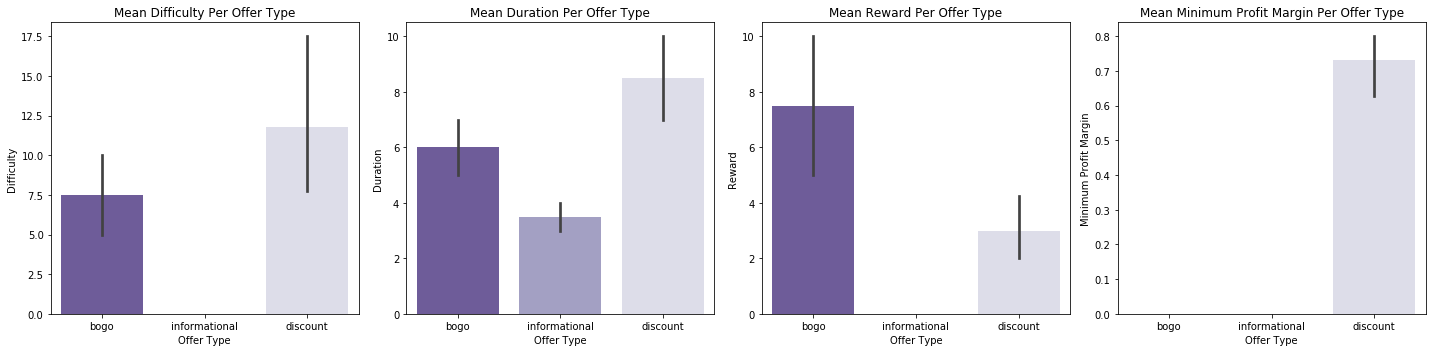

In [44]:
# Create sub-plots
fig, ax = plt.subplots(1,4, figsize = (20,5))

# Plot grouped box plots
for idx, col in enumerate(['difficulty','duration','reward','minimum_profit_margin']):
    sns.barplot(x='offer_type', y=col, data=offer_types, ax = ax[idx],palette='Purples_r')
    y_label = col.replace('_',' ').title()
    ax[idx].set_ylabel(y_label)
    ax[idx].set_xlabel('Offer Type')
    ax[idx].set_title('Mean ' + y_label + ' Per Offer Type')
    plt.tight_layout();

#### Observations:
- __Ten__ different offers in __three__ distinct categories: __BOGO__ offers (4x), __informational__ offers (2x) & __discounts__ (4x)
- BOGO and informational offers __do not__ guarantee positive effect on financials result as they have a minimum profit margin of 0%
- Discounts are the __only offers__ with positive minimum profit marging for completed offers (at least 71%)

In [45]:
# Possible to add channel analysis with ...
pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis=1).groupby('offer_type').sum()

,reward,difficulty,duration,email,mobile,social,web
offer_type,,,,,,,
bogo,30,30,24,4,4,3,3
discount,12,47,34,4,3,2,4
informational,0,0,7,2,2,1,1


### Profile

In [46]:
# Preview profile data
print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


check if there are any duplication in the data set.

In [47]:
# Check for duplicates and remove if true
if profile.drop_duplicates().shape != profile.shape:
    n_rows = profile.shape[0]
    profile = profile.drop_duplicates()
    print('Dropped {} duplicate rows from profile data set.'.format(n_rows - profile.shape[0]))
else:
    print('No duplicates found.')

No duplicates found.


In [48]:
# Check number of unique users
if profile['id'].nunique() == profile.shape[0]:
    print('Each records in the profile data represent one unique user.')
    print('The number of unique user is: ',len(profile.id.unique()))

Each records in the profile data represent one unique user.
The number of unique user is:  17000


### Problem found

In [49]:
# Let's check for missing values first
profile.isnull().sum() / profile.shape[0] * 100

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

In [50]:
# Then let's check for the meaning of the value "118" in the "age" column
profile['age'].value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

#### Observations
- Approx. 13% of users __didn't leave any__ profile information in the Starbucks app
- As we can see that the value counts of "age" column confirms our first intuition: Starbucks app users who didn't leave any information on gender and income also didn't leave any information on age and __missing values for were simply re-encoded as "118"__. 
- Will reverse this transformation to fill "118" as missing values first and then we will fix it later by imputing median to fill in the missing values.

In [51]:
# Reverse replacement of missing values in "age" columns
profile['age'] = np.where(profile['age'] == 118, np.nan, profile['age'])

# Check number of missing values (should match number of "118"s)
print('Number of missing values: {}'.format(profile['age'].isnull().sum()))

Number of missing values: 2175


In [52]:
# Create datetime from "became_member_on"
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', errors='ignore')

# Calculate member age in days
current_date = datetime.datetime.now()
profile['member_age'] = (current_date - profile['became_member_on']).dt.days / 365
profile = profile.drop('became_member_on', axis=1)

In [53]:
# Summary statistics
profile.describe().round(2)

,age,income,member_age
count,14825.00,14825.00,17000.00
mean,54.39,65404.99,3.32
std,17.38,21598.30,1.13
min,18.00,30000.00,1.91
25%,42.00,49000.00,2.48
50%,55.00,64000.00,2.89
75%,66.00,80000.00,4.07
max,101.00,120000.00,6.90


Summary statistics of the data:

The __median Starbucks app user__:
- Is __rather old__ with a median age of close 55 years
- Earns __more than twice__ as much money than median American: __\\$64,000 vs. \\$31,099__ (2016)
- Has started using the app for roughly __one and a half years__ ago for most of the customers

Steps on visualising demographic data 
- Plot distributions __in buckets__ to facilitate visual interpretation
- Plot distributions __as is__ in case the created buckets miss anything

In [54]:
# Create column buckets
profile['age_bucket'] = np.floor(profile['age'] / 10) * 10
profile['income_bucket'] = np.floor(profile['income'] / 10000) * 10
profile['member_age_bucket'] = np.floor(profile['member_age'])

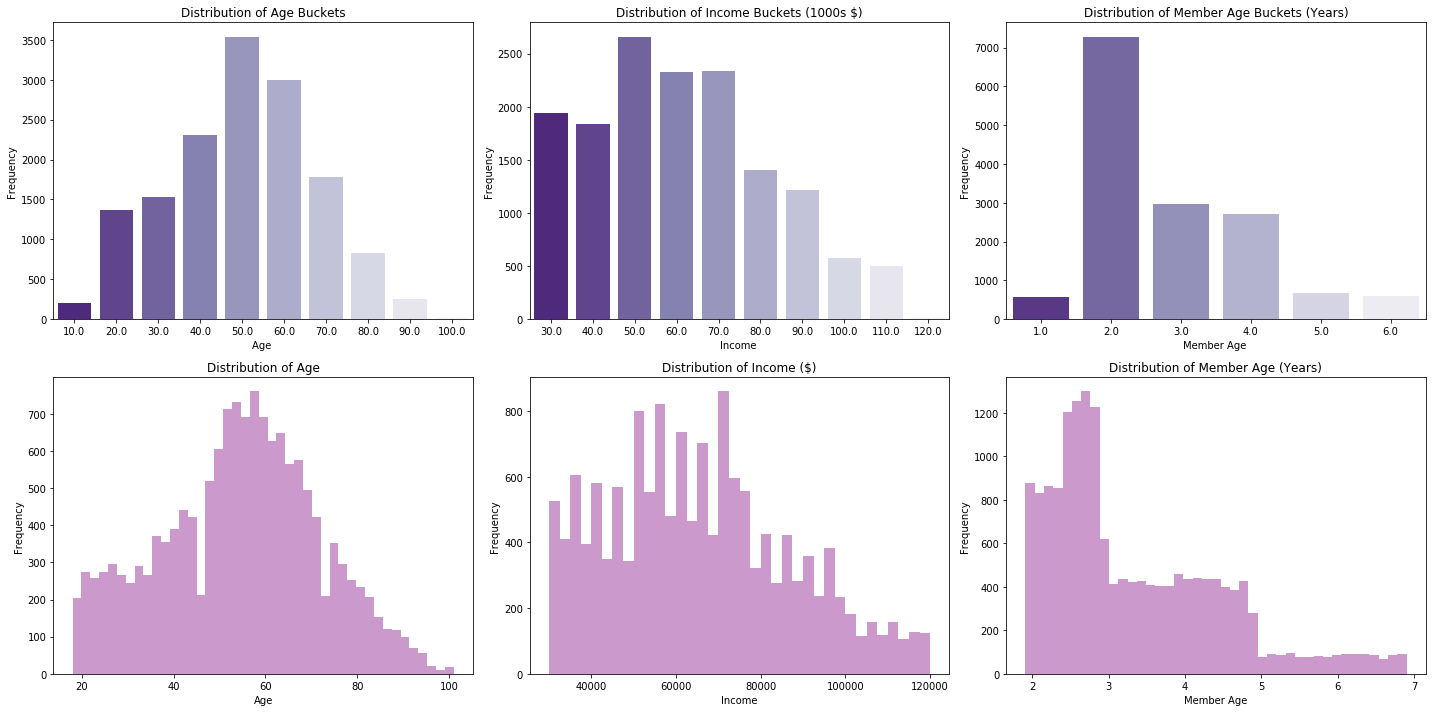

In [55]:
# Create sub-plots
fig, ax = plt.subplots(2,3, figsize = (20,10))

# Plot histograms across buckets
cols = ['age_bucket','income_bucket','member_age_bucket']

for idx, col in enumerate(cols):
    sns.barplot(x=col, y=col, data=profile.dropna(), estimator=lambda x: len(x), palette='Purples_r', ax=ax[0,idx])
    x_label = col.replace('bucket','').replace('_',' ').title()
    ax[0,idx].set_ylabel('Frequency')
    ax[0,idx].set_xlabel(x_label)
    ax[0,idx].set_title('Distribution of ' + x_label + 'Buckets')

# Plot histograms
cols = ['age','income','member_age']

for idx, col in enumerate(cols):
    sns.distplot(profile[col].dropna(), hist=True, kde=False, ax=ax[1,idx],color='purple')
    x_label = col.replace('_',' ').title()
    ax[1,idx].set_ylabel('Frequency')
    ax[1,idx].set_xlabel(x_label)
    ax[1,idx].set_title('Distribution of ' + x_label)
    plt.tight_layout()
    
# Adjust plot titles
ax[0,1].set_title('Distribution of Income Buckets (1000s $)')
ax[0,2].set_title('Distribution of Member Age Buckets (Years)')
ax[1,1].set_title('Distribution of Income ($)')
ax[1,2].set_title('Distribution of Member Age (Years)');

In [56]:
y_vars = ['difficulty','duration','reward','minimum_profit_margin']
i = 0
for row in range(2):
    for col in range(2):
        sns.barplot(x='offer_type', y=y_vars[i], data=offer_types, ax = ax[row,col])
        y_label = y_vars[i].replace('_',' ').title()
        ax[row,col].set_ylabel(y_label)
        ax[row,col].set_xlabel('Offer Type')
        ax[row,col].set_title('Mean ' + y_label + ' Per Offer Type')
        plt.tight_layout();
        i += 1
plt.show()

<Figure size 432x288 with 0 Axes>

#### Observations
- The __age__ of users is only slighty skewed to the right and __almost centered__ around the mean
- A slight right skew in the distribution of Starbucks app users' __income__ shows that only a small number of customer are very __wealthy people__
- The __member age__ histogram reveals how Starbucks was able to significantly __increase monthly registrations__ from time to time

### Transcript

In [57]:
# Preview transcript data
print(transcript.shape)
transcript.head()

(306534, 6)


,person,event,time,offer_id,amount,reward
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN


Before we dig deeper into the datat set, let's check for __duplicate rows__.

In [58]:
# Check for duplicates and remove if true
if transcript.drop_duplicates().shape != transcript.shape:
    n_rows = transcript.shape[0]
    transcript = transcript.drop_duplicates()
    print('Dropped {} duplicate rows from transcript data set.'.format(n_rows - transcript.shape[0]))
else:
    print('No duplicates found.')

Dropped 397 duplicate rows from transcript data set.


Each row in the transcript data frame describes __1 out of 306,137 events of the 17,000 registered Starbucks app users__. Users can either __receive, view and complete an offer__ or __make a transactions__. Whenever a user completes 1 out of the 10 offers available in the Starbucks portfolio he receives a reward. However, receiving rewards means making transactions first until an offer-specific amount is reached.

In order to get a feeling for how Starbucks app user interact with the offers they receive, how much money they spend and how different offers perform financially, we're going to collect some simple __aggregations of the data__ first.

In [59]:
# General overview
print('Number of events                          : {}'.format(transcript.shape[0]))
print('Number of users                           : {}'.format(transcript['person'].nunique()))
print('Number of days                            : {}'.format(int(np.floor(transcript['time'].max() / 24))))
print('Number of offers                          : {}'.format(transcript['offer_id'].nunique()))

# User counts
print('\nNumber of users who received an offer     : {}'.format(transcript[transcript['event'] == 'offer received']['person'].nunique()))
print('Number of users who viewed an offer       : {}'.format(transcript[transcript['event'] == 'offer viewed']['person'].nunique()))
print('Number of users who completed an offer    : {}'.format(transcript[transcript['event'] == 'offer completed']['person'].nunique()))
print('Number of users who made a transactions   : {}'.format(transcript[transcript['event'] == 'transaction']['person'].nunique()))

# Event counts
print('\nNumber of offer sendout days              : {}'.format(transcript[transcript['event'] == 'offer received']['time'].nunique()))
print('Number of offer receptions                : {}'.format(transcript[transcript['event'] == 'offer received'].shape[0]))
print('Number of offer views                     : {}'.format(transcript[transcript['event'] == 'offer viewed'].shape[0]))
print('Number of offer completions               : {}'.format(transcript[transcript['event'] == 'offer completed'].shape[0]))
print('Number of transactions                    : {}'.format(transcript[transcript['event'] == 'transaction'].shape[0]))

# Event counts per user
print('\nAverage number of offers received / user  : {:.2f}'.format(transcript[transcript['event'] == 'offer received'].groupby('person').count()['offer_id'].mean()))
print('Average number of offers viewed / users   : {:.2f}'.format(transcript[transcript['event'] == 'offer viewed'].groupby('person').count()['offer_id'].mean()))
print('Average number of offers completed / user : {:.2f}'.format(transcript[transcript['event'] == 'offer completed'].groupby('person').count()['offer_id'].mean()))
print('Average number of transactions / user     : {:.2f}'.format(transcript[transcript['event'] == 'transaction'].groupby('person').size().mean()))

# Event counts per offer
print('\nAverage number of recipients / offer      : {:.2f}'.format(transcript[transcript['event'] == 'offer received'].groupby('offer_id').size().mean()))
print('Average number of viewers / offer         : {:.2f}'.format(transcript[transcript['event'] == 'offer viewed'].groupby('offer_id').size().mean()))
print('Average number of completers / offer      : {:.2f}'.format(transcript[transcript['event'] == 'offer completed'].groupby('offer_id').size().mean()))

# Financials (totals)
print('\nTotal amount spent on transaction         : {:.2f}$'.format(transcript['amount'].sum()))
print('Total reward received on completion       : {:.2f}$'.format(transcript['reward'].sum()))

# Financials (averages)
print('\nAverage amount spent / transaction        : {:.2f}$'.format(transcript['amount'].mean()))
print('Average reward received / completion      : {:.2f}$'.format(transcript['reward'].mean()))
print('Average amount spent / user               : {:.2f}$'.format(transcript.groupby('person').mean()['amount'].mean()))
print('Average reward received / user            : {:.2f}$'.format(transcript.groupby('person').mean()['reward'].mean()))

Number of events                          : 306137
Number of users                           : 17000
Number of days                            : 29
Number of offers                          : 10

Number of users who received an offer     : 16994
Number of users who viewed an offer       : 16834
Number of users who completed an offer    : 12774
Number of users who made a transactions   : 16578

Number of offer sendout days              : 6
Number of offer receptions                : 76277
Number of offer views                     : 57725
Number of offer completions               : 33182
Number of transactions                    : 138953

Average number of offers received / user  : 4.49
Average number of offers viewed / users   : 3.43
Average number of offers completed / user : 2.60
Average number of transactions / user     : 8.38

Average number of recipients / offer      : 7627.70
Average number of viewers / offer         : 5772.50
Average number of completers / offer      : 4147.75

T

#### Summary
- Transcript data offer event for a __period of 29 days__
- Sendouts for the __10 offers__ from the portfolio happened on __6 distinct days__
- Eventhough __99%__ of all app users __received an offer__ at least once, we observe an overall __conversion rate of 57%__ only (= 33182 / 57725)
- Starbucks app users make __transactions every 3-4 days__ (= 29 / 8.38) and they __spend 13.68\\$__ on average
- __Every ~3rd__ of these transactions __completes an offer__ (= 8.38 / 2.60) leading to an average __reward of 4.75\\$__
- Because the distribution of transaction amounts across users is largely skewed, Starbucks is still able to achieve an overall __profit margin of 91%__, if we consider paying rewards the only costs in this analysis (= 1 - (162679.00 / 1775451.97)

Next, we will see __how offer events and transactions are distributed over time__ in order to understand the relationship between each other.

In [60]:
# Prepare data for plot of events
events = transcript.copy()

# Transform column values
events['event'] = events['event'].str.title()
events['time'] = np.floor(events['time'] / 24)

# Group data frame
events = pd.DataFrame(events.groupby(['event','time'],as_index=False).size()).reset_index()
events.columns = ['Event','Day','Number of Events']

events.head()

,Event,Day,Number of Events
0,Offer Completed,0.0,1014
1,Offer Completed,1.0,1025
2,Offer Completed,2.0,848
3,Offer Completed,3.0,655
4,Offer Completed,4.0,480


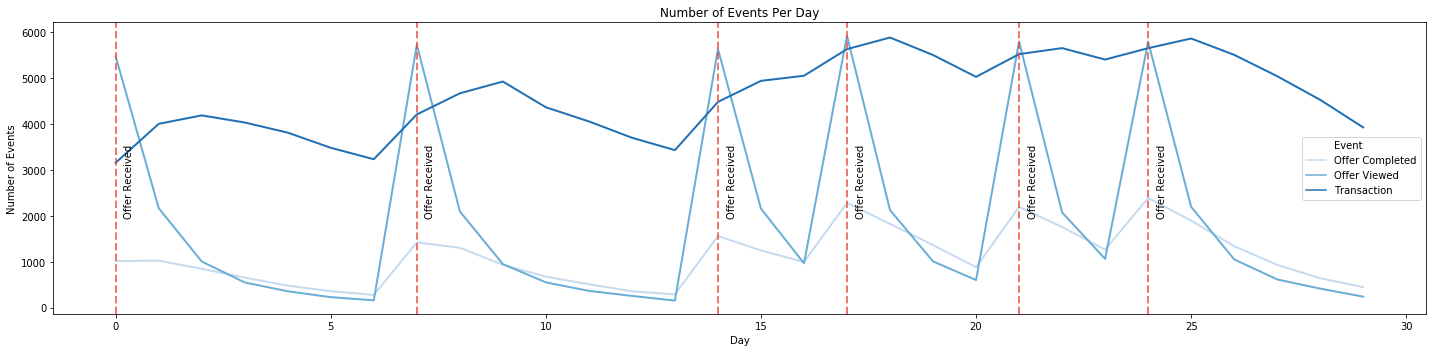

In [61]:
# Set plot size
fig, ax = plt.subplots(1,1, figsize = (20,5))

# Plot time series of offer events (excluding 'offer received')
ax = sns.lineplot(x="Day", y='Number of Events', hue="Event", data=events[events['Event'] != 'Offer Received'], palette='Blues', linewidth=2.)

# Plot lines for days of offer sendout
for time in events[events['Event'] == 'Offer Received']['Day']:
    plt.axvline(x=time, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
    plt.text(time+0.2, 2000, 'Offer Received', rotation=90)
    plt.tight_layout()
    
# Label plot
ax.set_ylabel('Number of Events')
ax.set_xlabel('Day')
ax.set_title('Number of Events Per Day')
plt.tight_layout()

#### Summary
- Starbucks sent out offers on __6 distinct days__ within the 29 days period covered in the transcript data frame
- The majority of offer __views__ will be happened on the __day of sendout__
- Actual __transactions peak slighty delayed__ within a few days after an offer was sent out
- Shorter __timespans between offer__ sendouts past day 14 seem to cause a larger overall number of transactions
- However, increase in overall number of transactions may also caused by a __growing number of previously__ seen offers

In [62]:
# Compare conversion rates for different offer types
# Get offer types
conversion_rate = transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left').groupby(['offer_type', 'event']).size().reset_index()

# Reshape data
conversion_rate = pd.pivot_table(conversion_rate, index='offer_type', columns='event', values=0).reset_index()
conversion_rate.columns = ['offer_type','offer_completed','offer_received','offer_viewed']

# Calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['offer_completed'] / conversion_rate['offer_viewed']

conversion_rate

,offer_type,offer_completed,offer_received,offer_viewed,conversion_rate
0,bogo,15501.0,30499.0,25449.0,0.609101
1,discount,17681.0,30543.0,21445.0,0.824481
2,informational,NaN,15235.0,10831.0,NaN


In [63]:
# Compare conversion rates for different offers
conversion_rate = transcript.copy()

# Reshape data
conversion_rate = pd.pivot_table(conversion_rate, index='offer_id', columns='event', values='person', aggfunc='size').reset_index()
conversion_rate.columns = ['offer_id','offer_completed','offer_received','offer_viewed']
conversion_rate['offer_completed'] = conversion_rate['offer_completed'].fillna(0)

# Calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['offer_completed'] / conversion_rate['offer_viewed']

conversion_rate

,offer_id,offer_completed,offer_received,offer_viewed,conversion_rate
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,3340.0,7668.0,2663.0,1.254225
1,2298d6c36e964ae4a3e7e9706d1fb8c2,5112.0,7646.0,7337.0,0.696743
2,2906b810c7d4411798c6938adc9daaa5,3964.0,7632.0,4118.0,0.962603
3,3f207df678b143eea3cee63160fa8bed,0.0,7617.0,4144.0,0.000000
4,4d5c57ea9a6940dd891ad53e9dbe8da0,3301.0,7593.0,7298.0,0.452316
5,5a8bc65990b245e5a138643cd4eb9837,0.0,7618.0,6687.0,0.000000
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,4303.0,7677.0,4171.0,1.031647
7,ae264e3637204a6fb9bb56bc8210ddfd,3635.0,7658.0,6716.0,0.541245
8,f19421c1d4aa40978ebb69ca19b0e20d,4262.0,7571.0,7264.0,0.586729
9,fafdcd668e3743c1bb461111dcafc2a4,5265.0,7597.0,7327.0,0.718575


Whereas it doesn't become quite clear in the comparison of offer types, it's pretty obvious when looking at conversion rates of distinct offers: Conversion rates of __greater than 100%__ are a strong indicator that some offers are __being completed without app users being aware__ of them. Thus, before we can continue to calculate offer specific conversion rates, we need to apply __additional pre-processing__ steps to the transcript data set.

However, to still get a feeling of how Starbucks offers are being completed we can use an __adjusted version__ of the conversion rate, knowing that the results don't capture the actual influence, but rather offer completion patterns in general.

In [64]:
# Add short version of "id" to portfolio data in order to facilitate working with offer ids e.g. for plotting
portfolio['offer_id_short'] = portfolio.index.values + 1

# Add offer types
conversion_rate = conversion_rate.merge(portfolio[['id','offer_id_short','offer_type']], left_on='offer_id', right_on='id', how='left')
conversion_rate = conversion_rate.drop(['id','offer_id'], axis=1)
conversion_rate = conversion_rate.rename(columns = {'offer_id_short':'offer_id'})
conversion_rate = conversion_rate.sort_values('offer_id')

# Calculate conversion rate
conversion_rate['conversion_rate'] = conversion_rate['offer_completed'] / conversion_rate['offer_received']

Then, as informational offers don't have any completion events we are going to __plot__ the adjusted conversion rates for both __BOGO and discount__ promotions.

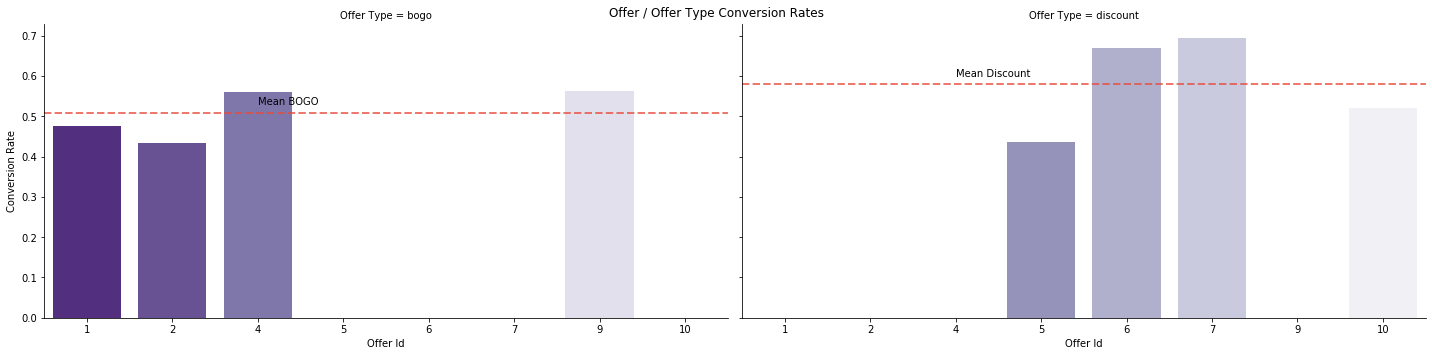

In [65]:
# Change column name and value formatting
conversion_rate.columns = [x.replace('_',' ').title() for x in conversion_rate.columns]

# Plot grouped barchat
p = sns.catplot(x='Offer Id', y='Conversion Rate', col='Offer Type', data=conversion_rate[conversion_rate['Offer Type'] != 'informational'],
                kind='bar', palette='Purples_r', height=5, aspect=2)

# Get reference values
bogo_mean = conversion_rate.groupby('Offer Type').mean()['Conversion Rate'][0]
discount_mean = conversion_rate.groupby('Offer Type').mean()['Conversion Rate'][1]

# Add reference lines
ax1, ax2 = p.axes[0]

ax1.axhline(y=bogo_mean, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
ax2.axhline(y=discount_mean, linestyle='--', linewidth=2., alpha=0.75, color='#e74c3c')
ax1.text(2, bogo_mean+0.02, "Mean BOGO")
ax2.text(2, discount_mean+0.02, "Mean Discount")

# Add title
p.fig.suptitle('Offer / Offer Type Conversion Rates')

plt.tight_layout();

#### Summary
- __Discounts__ seem to be the type of offer that are being __completed more often__ as compared to __buy-one-get-one__ offers (60% vs. 51% conversion rate)
- Conversion rate __standard deviations__ (12.27% vs. 6.39%) as well as both __graphs__ above reveal, that this really depends on the performance of individual offers
- BOGO offers clearly win in terms of __consistency__

In [66]:
# Reshape data
rewards = pd.pivot_table(transcript, index='offer_id', columns='event', values='reward', aggfunc='sum').reset_index()[['offer_id','offer completed']]
rewards.columns = ['offer_id','reward']

# Add offer types
rewards = rewards.merge(portfolio[['id','offer_id_short','offer_type']], left_on='offer_id', right_on='id', how='left')
rewards = rewards.drop(['id','offer_id'], axis=1)
rewards = rewards.rename(columns = {'offer_id_short':'offer_id'})
rewards = rewards.sort_values('offer_id')
rewards['reward'] = rewards['reward'].fillna(0)

# Add conversion rates
rewards['conversion_rate'] = conversion_rate['Conversion Rate']

rewards

,reward,offer_id,offer_type,conversion_rate
7,36350.0,1,bogo,0.474667
4,33010.0,2,bogo,0.434743
3,0.0,3,informational,0.000000
6,21515.0,4,bogo,0.560505
0,16700.0,5,discount,0.435576
1,15336.0,6,discount,0.668585
9,10530.0,7,discount,0.693037
5,0.0,8,informational,0.000000
8,21310.0,9,bogo,0.562938
2,7928.0,10,discount,0.519392


#### Summary
- For both discount offers as well as BOGO offers the plots reveal a rather __negative relationship (-0.56) between__ the amount of __rewards__ paid to app users for completing an offer and an offer's __conversion rate__
- __BOGO offers__ do not only have a __lower conversion rate__ on average, but are also __2.2x more expensive__ compared to the other offer type

***

### 3 Pre-Processing

The section is divided into the following parts:
1. Reading in files
2. Pre-processing of
    - Portfolio data
    - Profile data
    - Transcript data
    - Transaction events
    - Offer events

### Data Loader
- reload all data in a function

In [67]:
def load_data():
    ''' Loads portfolio, profile and transcript data from json files
    
    Args:
        None
    Returns:
        DataFrame: Returns three pandas data frames with: portfolio, profile and transcript data
    '''
    # Read in data
    print('Reading files ...')
    
    # Portfolio data
    portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
    print('... portfolio data imported. Shape of data: {}'.format(portfolio.shape))  
    
    # Profile data
    profile = pd.read_json('data/profile.json', orient='records', lines=True)
    print('... profile data imported. Shape of data: {}'.format(profile.shape))  
    
    # Transcript data
    transcript = load_transcript('data/transcript.json')
    transcript = transcript.drop_duplicates()
    print('... transcript data imported. Shape of data: {}'.format(transcript.shape))
    
    return portfolio, profile, transcript

In [68]:
# Run function
portfolio, profile, transcript = load_data()

Reading files ...
... portfolio data imported. Shape of data: (10, 6)
... profile data imported. Shape of data: (17000, 5)
... transcript data imported. Shape of data: (306137, 6)


### Portfolio Data
Add a __short version of "offer_id"__ for the ease of analysis

In [69]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [70]:
# Add a much simpler offer_id to the portfolio data set
def preprocess_portfolio(df):
    ''' Pre-processes portfolio data
    
    Adds an additional column "offer_id_short" as easier to read/
    work with variable to profile data.
      
    Args:
        df (DataFrame): Pandas data frame of portfolio data
    Returns:
        DataFrame: Returns a pandas data frame of portfolio data
    '''
    df['offer_id_short'] = df.index.values + 1
    
    return df

In [71]:
# Run function
portfolio = preprocess_portfolio(portfolio)

print(portfolio.shape)
portfolio.head()

(10, 7)


,reward,channels,difficulty,duration,offer_type,id,offer_id_short
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,3
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,5


### Profile Data
- add __user's member age__ as an extra column by using existing column "became_member_on" as mentioned earlier
- Replace "118" values as missing values in "age" columns and impute these missing values with median

In [72]:
# Pre-processing of profile data
def preprocess_profile(df):
    ''' Pre-processes profile data
    
    1. Convert "gender" column to str
    2. Adds an additional column "member_age" as days since app account registration
    3. Reverses encoding of missing values in "age" column
      
    Args:
        df (DataFrame): Pandas data frame of profile data
    Returns:
        DataFrame: Returns a pandas data frame of profile data
    '''
    # Convert "gender" to str
    df['gender'] = df['gender'].astype(str)
    
    # Create datetime from "became_member_on"
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d', errors='ignore')

    # Calculate member age in days
    current_date = datetime.datetime.now()
    df['member_age'] = (current_date - df['became_member_on']).dt.days
    df = df.drop('became_member_on', axis=1)
    
    # Reverse replacement of missing values in "age" columns
    df['age'] = np.where(df['age'] == 118, np.nan, df['age'])

    return df

In [73]:
# Run function
profile = preprocess_profile(profile)

print(profile.shape)
profile.head()

(17000, 5)


,gender,age,id,income,member_age
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1225
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,1072
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,710
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1139
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1052


### Transcript
Prepocessing steps will be taking placed for transcript data:
- Calculate __rewards__ received by app users
- Add __offer numbers__ to transcript data to keep track of situations where users receive the __same offer more than once__
- Add unique __transaction IDs__ to transcript data to keep track of "transaction" events
- Separate __transaction events__ including amounts paid and received from offer events
- Separate __offer events__ including timestamps from transaction events
- Make __comparison__ between transaction and offer events

In [74]:
# Retrieve timestamps and sums of rewards received by app users
def preprocess_rewards(df):
    ''' Retrieves rewards received by app users from transcript data
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
    Returns:
        DataFrame: Returns a pandas data frame of rewards received per user and timestamp
    '''
    rewards = df[df['event'] == 'offer completed'][['person','time','reward']]
    rewards = pd.DataFrame(rewards.groupby(['person','time'], as_index=False).sum())
    
    return rewards

In [75]:
transcript.head(10)

,person,event,time,offer_id,amount,reward
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN
5,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,8.57,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
9,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN


In [76]:
# Run function
rewards = preprocess_rewards(transcript)

print(rewards.shape)
rewards.head()

(30617, 3)


,person,time,reward
0,0009655768c64bdeb2e877511632db8f,414,5.0
1,0009655768c64bdeb2e877511632db8f,528,2.0
2,0009655768c64bdeb2e877511632db8f,576,2.0
3,0011e0d4e6b944f998e987f904e8c1e5,252,3.0
4,0011e0d4e6b944f998e987f904e8c1e5,576,10.0


In [77]:
# Create index for individual offers in order differentiate between the first time a person
# has received and offer and subsequent times

def create_offer_number(df):
    ''' Adds an offer number of the transcript data frame
    
    This number indicates whether a users received an offer for the first,
    second, third, etc. time.
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
    Returns:
        Series: Returns transcript data frame with additional offer numbers
    '''
    # Create flag for received offers
    df['has_received_offer'] = np.where(df['event'] == 'offer received', 1, np.nan)

    # Use flag to add row number to data frame which identify when an offer
    # was received the first, second, third, etc. time
#     df['offer_number'] = df.groupby(['person','offer_id','has_received_offer']).cumcount() + 1
    df['offer_number'] = df.groupby(['person','event']).cumcount() + 1

    # Remove row numbers for records that don't correspond to the event "offer received"
    df['offer_number'] = np.where(df['event'] != 'offer received', np.nan, df['offer_number'])

    # Apply group based forward fill of missing values for offer events related to
    # first, second, third, etc. time the same offer was received
    df['offer_number'] = df.groupby(['person','offer_id'])['offer_number'].apply(lambda x: x.ffill())
    df['offer_number'] = df.offer_number.ffill()

    # Drop columns
    df = df.drop('has_received_offer', axis=1)
    
    return df

In [78]:
# Run function
transcript = create_offer_number(transcript)

print(transcript.shape)
transcript.head()

(306137, 7)


,person,event,time,offer_id,amount,reward,offer_number
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,1.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,1.0
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,1.0
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2.0


In [79]:
# Create unique ids for each transaction
def create_transaction_id(df):
    '''
    Args:
        df (DataFrame): Pandas data frame of transcript data
    Returns:
        DataFrame: Returns transcript data frame with additional transation id
    '''
    # Add transaction id
    df['transaction_id'] = np.where(df['event'] == 'transaction', df.index.values, np.nan)
    
    return df

In [80]:
# Run function
transcript = create_transaction_id(transcript)

print(transcript.shape)
transcript.head()

(306137, 8)


,person,event,time,offer_id,amount,reward,offer_number,transaction_id
0,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,1.0,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,1.0,NaN
2,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,1.0,2.0
3,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2.0,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2.0,NaN


### Transactions

Before comparing transactions with offer periods we are going to create a separate data frame with __transaction events__ only. By adding a unique ID for each transaction in the "transcript" data frame we're able to account for multiple transactions with the same timestamp.

In [81]:
# Separation of transaction events
def preprocess_transactions(df, rewards):
    ''' Retrieves transaction events from transcript data
    
    Retrieves transaction events including timestamps, amounts paid as
    well as rewards received from transcript data
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
        rewards (DataFrame): Pandas data frame of received rewards
    Returns:
        DataFrame: Returns a pandas data frame of transactions including
                   the rewards received per user and timestamp
    '''
    # Transactions including paid amounts and received rewards
    transactions = df[df['event'] == 'transaction'].drop(['offer_id','offer_number','reward'], axis=1)
    transactions = transactions.merge(rewards, on=['person','time'], how='left')

    # Fill missing values
    transactions['reward'] = transactions['reward'].fillna(0)
    
    return transactions

In [82]:
# Run function
transactions = preprocess_transactions(transcript, rewards)

print(transactions.shape)
transactions.head()

(138953, 6)


,person,event,time,amount,transaction_id,reward
0,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,2.0,0.0
1,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,6.0,5.0
2,0009655768c64bdeb2e877511632db8f,transaction,528,14.11,10.0,2.0
3,0009655768c64bdeb2e877511632db8f,transaction,552,13.56,13.0,0.0
4,0009655768c64bdeb2e877511632db8f,transaction,576,10.27,15.0,2.0


### Offer Events

We have to find out if a transaction actually belongs to an offer period i.e. if a __transaction is actually influenced by an offer__, we need find those transaction that have a timestamp between an "offer viewed" and an "offer completed" event as well as finding its upper limit for that.

In [83]:
# Create offer events loop-up table for each user
def preprocess_offers(df, portfolio):
    ''' Creates a look-up table for offer events for each user
    
    Args:
        df (DataFrame): Pandas data frame of transcript data
        portfolio (DataFrame): Pandas data frame of offer portfolio
    Returns:
        DataFrame: Returns a pandas data frame of offer events
    '''
    # Reshape data
    offer_events = pd.pivot_table(df, index=['person', 'offer_id', 'offer_number'], columns='event', values='time')

    # Adjust columns / column names
    offer_events = offer_events.reset_index()
    offer_events.columns = ['person','offer_id','offer_number','time_completed','time_received','time_viewed']
    offer_events.index.name = None
    
    # Get additional offer information from "portfolio" data frame
    offer_events = offer_events.merge(portfolio[['id', 'duration','offer_id_short']],
                                      left_on='offer_id', right_on='id', how='left')

    # Calculate upper limit of individual offer periods by adding offer duration in hours
    # to the time when an offer was received
    offer_events['time_expired'] = offer_events['time_received'] + offer_events['duration'] * 24

    # A promotion ends for a user if he completes the offer or if the offer expires
    offer_events['time_ended'] = np.where(offer_events['time_completed'].isnull(),
                                          offer_events['time_expired'],
                                          offer_events['time_completed'])

    # Clean up
    offer_events = offer_events.drop(['id','duration','time_expired','offer_id'], axis=1)
    
    return offer_events

In [84]:
pd.pivot_table(transcript, index=['person', 'offer_id', 'offer_number'], columns='event', values='time')

event                                                                           offer completed  \
person                           offer_id                         offer_number                    
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 5.0                     576.0   
                                 3f207df678b143eea3cee63160fa8bed 2.0                       NaN   
                                 5a8bc65990b245e5a138643cd4eb9837 1.0                       NaN   
                                 f19421c1d4aa40978ebb69ca19b0e20d 3.0                     414.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 4.0                     528.0   
...                                                                                         ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5 3.0                     384.0   
                                                                  4.0                     414.0   
                                                                  6.0                     576.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 5.0                     504.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 1.0                      60.0   

event                                                                           offer received  \
person                           offer_id                         offer_number                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 5.0                    576.0   
                                 3f207df678b143eea3cee63160fa8bed 2.0                    336.0   
                                 5a8bc65990b245e5a138643cd4eb9837 1.0                    168.0   
                                 f19421c1d4aa40978ebb69ca19b0e20d 3.0                    408.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 4.0                    504.0   
...                                                                                        ...   
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5 3.0                    336.0   
                                                                  4.0                    408.0   
                                                                  6.0                    576.0   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 5.0                    504.0   
                                 fafdcd668e3743c1bb461111dcafc2a4 1.0                      0.0   

event                                                                           offer viewed  
person                           offer_id                         offer_number                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5 5.0                    NaN  
                                 3f207df678b143eea3cee63160fa8bed 2.0                  372.0  
                                 5a8bc65990b245e5a138643cd4eb9837 1.0                  192.0  
                                 f19421c1d4aa40978ebb69ca19b0e20d 3.0                  456.0  
                                 fafdcd668e3743c1bb461111dcafc2a4 4.0                  540.0  
...                                                                                      ...  
ffff82501cea40309d5fdd7edcca4a07 2906b810c7d4411798c6938adc9daaa5 3.0                  354.0  
                                                                  4.0                  414.0  
                                                                  6.0                  582.0  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9 5.0                  534.0  
                                 fafdcd668e3743c1bb461111dcafc2a4 1.0                    6.0  

[76277 rows x 3 columns]

In [85]:
# Run function
offer_events = preprocess_offers(transcript, portfolio)

print(offer_events.shape)
offer_events.head()

(76277, 7)


,person,offer_number,time_completed,time_received,time_viewed,offer_id_short,time_ended
0,0009655768c64bdeb2e877511632db8f,5.0,576.0,576.0,NaN,10,576.0
1,0009655768c64bdeb2e877511632db8f,2.0,NaN,336.0,372.0,3,432.0
2,0009655768c64bdeb2e877511632db8f,1.0,NaN,168.0,192.0,8,240.0
3,0009655768c64bdeb2e877511632db8f,3.0,414.0,408.0,456.0,9,414.0
4,0009655768c64bdeb2e877511632db8f,4.0,528.0,504.0,540.0,7,528.0


### Comparison of Transactions & Offer Events

As we have known that how users __interacted with promotions__ when they received the offer type, we're able to evaluate whether a transaction occured __during an offer__ or __non-offer period__, which gonna be useful for having these kind of information.

In [86]:
def compare_transactions(df, offer_events, portfolio):
    ''' Checks if offers had influence on transactions
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        offer_events (DataFrame): Pandas data frame of offer events
        portfolio (DataFrame): Pandas data frame of offer portfolio
    Returns:
        DataFrame: Returns a pandas data frame of transactions events
    '''
    # Merge transactions and offer events
    df = df.merge(offer_events, on='person', how='left')

    # Only keep offer ids for cases where transaction occured during an offer period
    # Please note: It's possible that a user's transaction was influenced by more than one offer
    df['offer_id_short'] = np.where((df['time'].astype(float) >= df['time_viewed']) &
                                    (df['time'].astype(float) <= df['time_ended']),
                                    df['offer_id_short'],
                                    np.nan)
    
    # Generate fill value for transactions that were influenced by offers for reshaping below
    df['response_to_offer'] = np.where(~df['offer_id_short'].isnull(), 1, np.nan)
    
    # Fill missing offer ids with 0s in order to avoid removal of missing values in "pd.pivot_table"
    df['offer_id_short'] = df['offer_id_short'].fillna(0)
    
    # Get offer types, difficulties and rewards
    df = df.merge(portfolio[['offer_id_short','offer_type','difficulty','reward']], on='offer_id_short', how='left')
    df = df.rename(columns = {'reward_x':'reward_received', 'reward_y':'reward_expected'})
    
    # Generate fill value for difficulty and expected reward
    df['difficulty'] = df['difficulty'].fillna(0)
    df['reward_expected'] = df['reward_expected'].fillna(0)
    
    # Fill missing offer types with string value in order to avoid removal of missing values in "pd.pivot_table"
    df['offer_type'] = df['offer_type'].fillna('none')
    
    # Drop unneccessary columns before reshaping
    df = df.drop(['event','time_completed','time_received','time_viewed','time_ended','offer_number'], axis=1)
    
    return df

In [87]:
# Run function
transactions = compare_transactions(transactions, offer_events, portfolio)

print(transactions.shape)
transactions.head()

(638479, 10)


,person,time,amount,transaction_id,reward_received,offer_id_short,response_to_offer,offer_type,difficulty,reward_expected
0,0009655768c64bdeb2e877511632db8f,228,22.16,2.0,0.0,0.0,NaN,none,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,228,22.16,2.0,0.0,0.0,NaN,none,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,228,22.16,2.0,0.0,8.0,1.0,informational,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,228,22.16,2.0,0.0,0.0,NaN,none,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,228,22.16,2.0,0.0,0.0,NaN,none,0.0,0.0


It is found that there are a lot of  __duplicate rows__ (from 138,953 to 638,479 rows) after joining the dataset. However, we will make it back to original shape in the __next pre-processing step__.

In [88]:
def pivot_transactions(df):
    ''' Reshapes transaction data from long to wide format
    
    Reshapes transaction data from long to wide format and binarizes
    interactions with offers
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
    Returns:
        DataFrame: Returns a pandas data frame of transactions events
    '''
    # Define index columns
    idx = ['person','time','transaction_id','amount','reward_received']

    # Reshape data with offer types
    df_types = pd.pivot_table(df.drop('offer_id_short', axis=1),
                              index=idx, columns=['offer_type'], aggfunc=np.sum)
    df_types = df_types.reset_index()
    df_types = df_types.drop([('response_to_offer','none'),('difficulty','none'),('reward_expected','none')], axis=1)
    df_types.columns = ['person','time','transaction_id','amount','reward_received',
                        'difficulty_bogo','difficulty_discount','difficulty_informational',
                        'n_bogo','n_discount','n_informational',
                        'reward_expected_bogo','reward_expected_discount','reward_expected_informational']  

    # Sum up offer difficulties and expected rewards
    df_types['difficulty'] = df_types[['difficulty_bogo','difficulty_discount','difficulty_informational']].sum(axis=1)
    df_types['reward_expected'] = df_types[['reward_expected_bogo','reward_expected_discount','reward_expected_informational']].sum(axis=1)
    
    # Drop columns
    df_types = df_types.drop(['difficulty_bogo','difficulty_discount','difficulty_informational'], axis=1)
    df_types = df_types.drop(['reward_expected_bogo','reward_expected_discount','reward_expected_informational'], axis=1)

    # Reshape data with offer numbers
    df_ids = pd.pivot_table(df.drop(['offer_type','difficulty','reward_expected'], axis=1),
                            index=idx, columns=['offer_id_short'], aggfunc=np.sum)
    df_ids = df_ids.reset_index()
    df_ids = df_ids.drop(('response_to_offer',0.), axis=1)
    df_ids.columns = ['person','time','transaction_id','amount','reward_received','n_offer_1','n_offer_2',
                      'n_offer_3','n_offer_4','n_offer_5','n_offer_6','n_offer_7','n_offer_8',
                      'n_offer_9','n_offer_10']
    
    # Combine the two
    df_combined = df_types.merge(df_ids, on=['person','time','transaction_id','amount','reward_received'], how='left')
    
    # Formatting and clean up
    df_combined = df_combined.drop(['transaction_id'], axis=1)
    df_combined = df_combined.fillna(0)
    
    # Replace all values greater than 1 with 1 to have binary columns for offer types and offers
    # Reason behind this is the very low number of cases where a user actually see received the
    # same offer multiple time directly after another. This could also not be intended by Starbucks ...
    offer_cols = ['n_bogo','n_discount','n_informational','n_offer_1','n_offer_2','n_offer_3','n_offer_4',
                  'n_offer_5','n_offer_6','n_offer_7','n_offer_8','n_offer_9','n_offer_10']
    df_combined[offer_cols] = np.where(df_combined[offer_cols] > 1, 1, df_combined[offer_cols])
    
    return df_combined

Now we have come to a point that: 
- A data frame where each record represents a __transaction__, including the __amount paid__ and the __reward received__ whenever the transaction completed an offer by Starbucks. 
- We also know whether a transaction was __influenced by an offer and which type of offers are used__
- Last but not least, columns like "difficulty" and "reward_expected" show __how challenging__ it was for a user to complete an offer and what he was going to __get in return__.

The following function will execute all these preprocessing mentioned above to get the data ready for modelling

In [89]:
# Pre-processing function
def pre_processing():
    ''' Runs pre-processing pipeline on data sets
    
    Args:
        None
    Returns:
        DataFrame: Returns five pandas data frames of:
                   - offer portfolio
                   - profile data
                   - transcript data
                   - transaction data
                   - offer_events
    '''
    # Read in data
    portfolio, profile, transcript = load_data()
    
    # Run pre-processing steps and output data shapes
    print('\nPre-processing data ...')
    portfolio = preprocess_portfolio(portfolio)
    print('... portfolio data processed. Shape of data: {}'.format(portfolio.shape))
    profile = preprocess_profile(profile)
    print('... profile data processed. Shape of data: {}'.format(profile.shape))
    rewards = preprocess_rewards(transcript)
    print('... rewards data processed. Shape of data: {}'.format(rewards.shape))
    transcript = create_offer_number(transcript)
    transcript = create_transaction_id(transcript)
    print('... transcript data processed. Shape of data: {}'.format(transcript.shape))
    transactions = preprocess_transactions(transcript, rewards)
    print('... transations data processed. Shape of data: {}'.format(transactions.shape))
    offer_events = preprocess_offers(transcript, portfolio)
    print('... offer data processed. Shape of data: {}'.format(offer_events.shape))
    
    # Combinding data frames
    print('\nCombining data ...')
    transactions = compare_transactions(transactions, offer_events, portfolio)
    print('... transaction events and offer periods merged and compared. Shape of data: {}'.format(transactions.shape))
    transactions = pivot_transactions(transactions)
    print('... transaction events reshaped. Shape of data: {}'.format(transactions.shape))
    
    # Return original data frames as well as preprocessed version when neccessary
    return portfolio, profile, transcript, transactions, offer_events

In [90]:
# Run function
portfolio, profile, transcript, transactions, offer_events = pre_processing()

Reading files ...
... portfolio data imported. Shape of data: (10, 6)
... profile data imported. Shape of data: (17000, 5)
... transcript data imported. Shape of data: (306137, 6)

Pre-processing data ...
... portfolio data processed. Shape of data: (10, 7)
... profile data processed. Shape of data: (17000, 5)
... rewards data processed. Shape of data: (30617, 3)
... transcript data processed. Shape of data: (306137, 8)
... transations data processed. Shape of data: (138953, 6)
... offer data processed. Shape of data: (76277, 7)

Combining data ...
... transaction events and offer periods merged and compared. Shape of data: (638479, 10)
... transaction events reshaped. Shape of data: (138953, 19)


***

## 4. Model Building

### Multi-classification Model
- as the thing that we are going to predict is the offer type that lead an individual to spend more compared to other offer type, so it will be multi-classification model since the target variable will consist of five offer type that we are going to discuss later
- so we are going to reorganise the dataset into user-based



The following section is organized as follows:
- Additional Feature Engineering
- Training
- Validation
- Tuning
- Offer Type Prediction

In [91]:
# Let's make sure we have a fresh set of our data
print('portfolio shape is: ', portfolio.shape)
print('profile shape is: ', profile.shape)
print('transcript shape is: ', transcript.shape)
print('transactions shape is: ', transactions.shape)
print('offer_events shape is: ', offer_events.shape)

portfolio shape is:  (10, 7)
profile shape is:  (17000, 5)
transcript shape is:  (306137, 8)
transactions shape is:  (138953, 19)
offer_events shape is:  (76277, 7)


In [92]:
# Add column for profit
transactions['profit'] = transactions['amount'] - transactions['reward_received']

In [93]:
# Add ratio between expected reward and difficulty
transactions['reward_per_difficulty'] = (transactions['reward_expected'] / transactions['difficulty']).fillna(0)

In [94]:
# drop n_offer_1 to n_offer_9 because we would like to focus on 4 types only (BOGO, Discount, Informational and no offer)
transactions = transactions.drop(['n_offer_1','n_offer_2','n_offer_3','n_offer_4','n_offer_5','n_offer_6','n_offer_7','n_offer_8','n_offer_9','n_offer_10'],axis=1)

In [95]:
# create a value that has not given any offer to user
transactions['n_no_offer'] = np.where((transactions.n_bogo == 0) 
                          & (transactions.n_discount == 0) 
                          & (transactions.n_informational == 0),1,0)

# dataset for each offer type
n_bogo = transactions[transactions.n_bogo == 1]
n_discount = transactions[transactions.n_discount == 1]
n_informational = transactions[transactions.n_informational == 1]
n_no_offer = transactions[(transactions.n_no_offer == 1)]

n_bogo = n_bogo.drop(['n_discount','n_informational','n_no_offer'],axis=1)
n_discount = n_discount.drop(['n_bogo','n_informational','n_no_offer'],axis=1)
n_informational = n_informational.drop(['n_discount','n_bogo','n_no_offer'],axis=1)
n_no_offer = n_no_offer.drop(['n_discount','n_bogo','n_informational'],axis=1)

### Calculate all the metrics and statistics for each customer ready for modelling
- separate each type of offer first
- calculate the statistics for each person purchasing behaviour for all offer type

In [96]:
## Bogo offer type details for each person
bogo_per_person = n_bogo.groupby('person').agg({'n_bogo':'sum',
                                                'time':'mean',
                                                'amount':'mean',
                                                'reward_received':'mean',
                                                'difficulty':'mean',
                                                'reward_expected':'mean',
                                                'profit':'mean',
                                                'reward_per_difficulty':'mean'}).reset_index()

bogo_per_person = bogo_per_person.rename(columns={'time':'bogo_time','amount':'bogo_amount','reward_received':'bogo_reward_received','difficulty':'bogo_difficulty','reward_expected':'bogo_reward_expected','profit':'bogo_profit','reward_per_difficulty':'bogo_reward_per_difficulty'})


## Discount offer type details for each person
discount_per_person = n_discount.groupby('person').agg({'n_discount':'sum',
                                                        'time':'mean',
                                                        'amount':'mean',
                                                        'reward_received':'mean',
                                                        'difficulty':'mean',
                                                        'reward_expected':'mean',
                                                        'profit':'mean',
                                                        'reward_per_difficulty':'mean'}).reset_index()

discount_per_person = discount_per_person.rename(columns={'time':'discount_time','amount':'discount_amount','reward_received':'discount_reward_received','difficulty':'discount_difficulty','reward_expected':'discount_reward_expected','profit':'discount_profit','reward_per_difficulty':'discount_reward_per_difficulty'})


## Informational offer type details for each person
inform_per_person = n_informational.groupby('person').agg({'n_informational':'sum',
                                                           'time':'mean',
                                                           'amount':'mean',
                                                           'reward_received':'mean',
                                                           'difficulty':'mean',
                                                           'reward_expected':'mean',
                                                           'profit':'mean',
                                                           'reward_per_difficulty':'mean'}).reset_index()

inform_per_person = inform_per_person.rename(columns={'time':'inform_time','amount':'inform_amount','reward_received':'inform_reward_received','difficulty':'inform_difficulty','reward_expected':'inform_reward_expected','profit':'inform_profit','reward_per_difficulty':'inform_reward_per_difficulty'})


## No offer type details for each person
nooffer_per_person = n_no_offer.groupby('person').agg({'n_no_offer':'sum',
                                                       'time':'mean',
                                                       'amount':'mean',
                                                       'reward_received':'mean',
                                                       'difficulty':'mean',
                                                       'reward_expected':'mean',
                                                       'profit':'mean',
                                                       'reward_per_difficulty':'mean'}).reset_index()

nooffer_per_person = nooffer_per_person.rename(columns={'time':'nooffer_time','amount':'nooffer_amount','reward_received':'nooffer_reward_received','difficulty':'nooffer_difficulty','reward_expected':'nooffer_reward_expected','profit':'nooffer_profit','reward_per_difficulty':'nooffer_reward_per_difficulty'})

#### Merge all offer type dataset

In [97]:
# Merge transaction events and offer influence with profile data
def add_profiles(df, profile):
    ''' Adds app account profile data to transactions events
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        profile (DataFrame): Pandas data frame of app account profiles
    Returns:
        DataFrame: Returns a pandas data frame of transactions events and profile data
    '''
    print('... adding profile data')
    
    df = df.merge(profile, left_on='person', right_on='id', how='left')
    df = df.drop('id', axis=1)
    
    return df

# Add app user account profile data
transactions =  add_profiles(transactions, profile)

print(transactions.shape)
transactions.head()

... adding profile data
(138953, 16)


,person,time,amount,reward_received,n_bogo,n_discount,n_informational,difficulty,reward_expected,profit,reward_per_difficulty,n_no_offer,gender,age,income,member_age
0,0009655768c64bdeb2e877511632db8f,228,22.16,0.0,0.0,0.0,1.0,0.0,0.0,22.16,0.0,0,M,33.0,72000.0,1157
1,0009655768c64bdeb2e877511632db8f,414,8.57,5.0,0.0,0.0,1.0,0.0,0.0,3.57,0.0,0,M,33.0,72000.0,1157
2,0009655768c64bdeb2e877511632db8f,528,14.11,2.0,0.0,0.0,0.0,0.0,0.0,12.11,0.0,1,M,33.0,72000.0,1157
3,0009655768c64bdeb2e877511632db8f,552,13.56,0.0,0.0,0.0,0.0,0.0,0.0,13.56,0.0,1,M,33.0,72000.0,1157
4,0009655768c64bdeb2e877511632db8f,576,10.27,2.0,0.0,0.0,0.0,0.0,0.0,8.27,0.0,1,M,33.0,72000.0,1157


In [98]:
# Merge all offer type dataset
all_df = profile.merge(bogo_per_person,left_on='id',right_on='person',how='left')
all_df = all_df.merge(discount_per_person,left_on='id',right_on='person',how='left')
all_df = all_df.merge(inform_per_person,left_on='id',right_on='person',how='left')
all_df = all_df.merge(nooffer_per_person,left_on='id',right_on='person',how='left')
all_df = all_df.drop(['person_x','person_y','id'],axis=1)

In [99]:
## fill missing value
all_df.gender = all_df.gender.replace('None',all_df.gender.mode())
all_df.age = all_df.age.fillna(value=all_df.age.median())
all_df.income = all_df.income.fillna(value=all_df.income.median())
all_df = all_df.fillna(0)

Define __our target metrics__ based on the amount they spent on each type offer

In [100]:
all_df['max_profit_offer_type'] = 'None'
all_df['max_profit_offer_type'] = np.where((all_df.bogo_profit > all_df.discount_profit) &
                                           (all_df.bogo_profit > all_df.inform_profit) &
                                           (all_df.bogo_profit > all_df.nooffer_profit),'bogo',all_df['max_profit_offer_type'])

all_df['max_profit_offer_type'] = np.where((all_df.discount_profit > all_df.bogo_profit) &
                                           (all_df.discount_profit > all_df.inform_profit) &
                                           (all_df.discount_profit > all_df.nooffer_profit),'discount',all_df['max_profit_offer_type'])

all_df['max_profit_offer_type'] = np.where((all_df.inform_profit > all_df.discount_profit) &
                                           (all_df.inform_profit > all_df.bogo_profit) &
                                           (all_df.inform_profit > all_df.nooffer_profit),'inform',all_df['max_profit_offer_type'])

all_df['max_profit_offer_type'] = np.where((all_df.nooffer_profit > all_df.discount_profit) &
                                           (all_df.nooffer_profit > all_df.inform_profit) &
                                           (all_df.nooffer_profit > all_df.bogo_profit),'no_offer',all_df['max_profit_offer_type'])

__Dummy encoding__ the categorical column "gender".

In [101]:
def add_dummies(df, colname):
    ''' Add dummy variables to data frame
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        colname (str): Name of column to create dummies of
    Returns:
        DataFrame: Returns a pandas data frame of transactions events and dummy variables
    '''
    print('... adding dummy variables')
    
    # Create dummies
    gender_dummies = pd.get_dummies(df[colname], prefix=colname, prefix_sep='_')
    df = pd.concat([df, gender_dummies], axis=1)
    
    # Drop categorical column
    df = df.drop(colname, axis=1)
    
    return df

In [102]:
# Dummy-encode "gender"
all_df =  add_dummies(all_df, 'gender')

print(all_df.shape)
all_df.head()

... adding dummy variables
(17000, 40)


,age,income,member_age,n_bogo,bogo_time,bogo_amount,bogo_reward_received,bogo_difficulty,bogo_reward_expected,bogo_profit,bogo_reward_per_difficulty,n_discount,discount_time,discount_amount,discount_reward_received,discount_difficulty,discount_reward_expected,discount_profit,discount_reward_per_difficulty,n_informational,inform_time,inform_amount,inform_reward_received,inform_difficulty,inform_reward_expected,inform_profit,inform_reward_per_difficulty,n_no_offer,nooffer_time,nooffer_amount,nooffer_reward_received,nooffer_difficulty,nooffer_reward_expected,nooffer_profit,nooffer_reward_per_difficulty,max_profit_offer_type,gender_F,gender_M,gender_None,gender_O
0,55.0,64000.0,1225,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,9.0,527.333333,2.266667,0.555556,24.555556,6.111111,1.711111,0.236386,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,discount,0,1,0,0
1,55.0,112000.0,1072,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,3.0,230.0,25.670000,1.666667,0.0,0.0,24.003333,0.0,no_offer,1,0,0,0
2,55.0,64000.0,710,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,6.0,456.0,2.383333,0.000000,0.0,0.0,2.383333,0.0,no_offer,0,0,1,0
3,75.0,100000.0,1139,2.0,321.0,20.805,10.0,7.5,7.5,10.805,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,231.0,24.695,0.0,0.0,0.0,24.695,0.0,3.0,352.0,22.756667,0.000000,0.0,0.0,22.756667,0.0,inform,1,0,0,0
4,55.0,64000.0,1052,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,1.0,234.000000,1.090000,0.000000,20.000000,5.000000,1.090000,0.250000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,2.0,438.0,1.780000,0.000000,0.0,0.0,1.780000,0.0,no_offer,0,0,1,0


First, I'm going to check for remaining missing values in the data set. As there shouldn't be any originating from the transaction data, some might have been __introduced when merging__ it with the profile data set (as we saw already in the exploratory analysis).

In [103]:
# Check for missing values
all_df.isnull().sum()

age                               0
income                            0
member_age                        0
n_bogo                            0
bogo_time                         0
bogo_amount                       0
bogo_reward_received              0
bogo_difficulty                   0
bogo_reward_expected              0
bogo_profit                       0
bogo_reward_per_difficulty        0
n_discount                        0
discount_time                     0
discount_amount                   0
discount_reward_received          0
discount_difficulty               0
discount_reward_expected          0
discount_profit                   0
discount_reward_per_difficulty    0
n_informational                   0
inform_time                       0
inform_amount                     0
inform_reward_received            0
inform_difficulty                 0
inform_reward_expected            0
inform_profit                     0
inform_reward_per_difficulty      0
n_no_offer                  

In [104]:
print(all_df.nooffer_difficulty.unique())
print(all_df.nooffer_reward_expected.unique())
print(all_df.nooffer_reward_per_difficulty.unique())

# these three columns only have one unique value, so it does not provide any information and value for model prediction
drop_col = ['nooffer_difficulty','nooffer_reward_expected','nooffer_reward_per_difficulty']
all_df = all_df.drop(drop_col,axis=1)

[0.]
[0.]
[0.]


#### Summary
- It is found that there are many highly correlated features between independent variables
- Large correlations are likely to lead to inaccurate model especially linear models such as linear regression and logistic regression
- Possible __solutions__:
    - Remove highly correlated features
    - Regularized algorithm such as lasso/ridge/elastic net regression
    - Tree-based methods such as random forest or xgboost or lightgbm

Tree based model will be used for this project since tree based model is more robust to high correlated features, outliers and features that are not on the same magnitude.

## Clustering
- we can do clustering on the dataset to have more features that will help improving the model on predicting target variable more accurately

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans    
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score

clean_df = all_df.copy()

In [106]:
int_col = ['n_bogo','n_discount','n_informational','n_no_offer']
clean_df[int_col] = clean_df[int_col].astype(int)

num_col = clean_df.select_dtypes(include='float64').columns

scaler = StandardScaler()
scaler.fit(all_df[num_col])

clean_df[num_col] = pd.DataFrame(scaler.transform(all_df[num_col]))
clean_df[num_col] = pd.DataFrame(data=clean_df[num_col],
                             index=clean_df[num_col].index,
                             columns=clean_df[num_col].columns)

In [107]:
clean_df.columns

Index(['age', 'income', 'member_age', 'n_bogo', 'bogo_time', 'bogo_amount',
       'bogo_reward_received', 'bogo_difficulty', 'bogo_reward_expected',
       'bogo_profit', 'bogo_reward_per_difficulty', 'n_discount',
       'discount_time', 'discount_amount', 'discount_reward_received',
       'discount_difficulty', 'discount_reward_expected', 'discount_profit',
       'discount_reward_per_difficulty', 'n_informational', 'inform_time',
       'inform_amount', 'inform_reward_received', 'inform_difficulty',
       'inform_reward_expected', 'inform_profit',
       'inform_reward_per_difficulty', 'n_no_offer', 'nooffer_time',
       'nooffer_amount', 'nooffer_reward_received', 'nooffer_profit',
       'max_profit_offer_type', 'gender_F', 'gender_M', 'gender_None',
       'gender_O'],
      dtype='object')

In [108]:
# scaled data
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(clean_df.drop('max_profit_offer_type',axis=1))
    cluster_labels = kmeans.labels_
    sil_score = silhouette_score(clean_df.drop('max_profit_offer_type',axis=1), cluster_labels, metric='euclidean')
    print("K: {}, Silhouette Score: {}".format(k, sil_score))
    

K: 2, Silhouette Score: 0.6629665286344827
K: 3, Silhouette Score: 0.6576934106113436
K: 4, Silhouette Score: 0.5967343756025475
K: 5, Silhouette Score: 0.5580883073341903
K: 6, Silhouette Score: 0.5597151642312527
K: 7, Silhouette Score: 0.5594413969769303
K: 8, Silhouette Score: 0.5449094303951505
K: 9, Silhouette Score: 0.5453642982859619


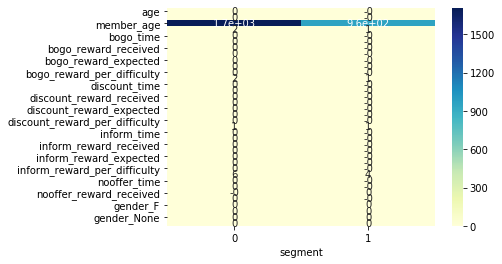

In [109]:
kmeans = KMeans(n_clusters=2)
kmeansoutput = kmeans.fit(clean_df.drop('max_profit_offer_type',axis=1))

clean_df = clean_df.assign(segment = kmeans.labels_)

df_avg = clean_df.groupby(['segment']).mean().round(0)
df_avg

sns.heatmap(df_avg.T, cmap='YlGnBu',annot=True)
plt.show()

it seems like the k-means is not able to nicely separate the groups in the dataset as the only difference between both segment is just member age, while k-means is not able to capture the variations for the rest of the features.

### Training

In [110]:
# Set up pipeline
def build_pipeline(df, features, target):
    ''' Build an sklearn pipeline
    
    Args:
        df (DataFrame): Pandas data frame of transactions data
        features (list): List of independent features
        target (str): Name of dependent feature
    Returns:
        DataFrame: Pandas data frame of independent variables from training data
        DataFrame: Pandas data frame of independent variables from testing data
        Series: Pandas series of dependent variables from training data
        Series: Pandas series of dependent variables from testing data
    '''
    print('Transforming data set ...')

    # Separate data
    X = df[features].copy()
    y = df[target].copy()

    # Split data
    print('\nSplitting data set ...')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    print('... splitting done.')
    print('... shape of training data X: {}, y {}'.format(X_train.shape, y_train.shape))
    print('... shape of testing data  X: {},  y {}'.format(X_test.shape, y_test.shape))
    
    print('\nBuilding pipeline ...')
    
    num_features = X.columns.tolist()
    
    print('... pipeline ready.')
    
    return X_train, X_test, y_train, y_test

In [111]:
def run_validation(X_train, X_test, y_train, y_test, model):
    ''' Runs model validation on test and training data
    
    Args:
        X_train (DataFrame): Pandas data frame of independent variables from training data
        X_test (DataFrame): Pandas data frame of independent variables from testing data
        y_train (Series): Pandas series of dependent variables from training data
        y_test (Series): Pandas series of dependent variables from testing data
        model (classifier): Fitted model or pipeline
    Returns:
        Array: Returns an array with predicted values from training data
        Array: Returns an array with predicted values from testing data
        Dict: Returns a dictionary of validation metrics
    '''
    # Predict results for training and testing data
    train_preds = model.fit(X_train,y_train)
    test_preds = model.predict(X_test)
    
    metrics = dict()
    
    metrics['test_accuracy'] = accuracy_score(test_preds, y_test)
    
    # Testing
    print('\nValidation metrics:')
    print('Accuracy score       : {:.4f}'.format(metrics['test_accuracy']))
    
    return train_preds, test_preds, metrics

In [112]:
## Define xgboost multi-classifier(s)
xgb_multi = xgb.XGBClassifier(objective ='multi:softmax',silent=1, nthread=-1, n_jobs=-1, num_classes=5,
                              reg_alpha=0.9, reg_lambda=0.1, early_stopping_rounds=15,n_estimators=500, 
                              learning_rate=0.01)

In [113]:
x = {'bogo':0,
     'discount':1,
     'inform':2,
     'no_offer':3,
     'None':4}

clean_df['max_profit_offer_type'] = clean_df['max_profit_offer_type'].map(x)

In [114]:
# Define features/target
target = 'max_profit_offer_type'

# drop these profit features that will lead to data leakage
drop_col = ['max_profit_offer_type','bogo_profit', 'discount_profit', 'inform_profit','nooffer_profit']
features = clean_df.drop(drop_col,axis=1).columns

... and build our __pipelines__ so they are ready for training.

In [115]:
# Build pipeline(s)
X_train, X_test, y_train, y_test = build_pipeline(clean_df, features, target)

Transforming data set ...

Splitting data set ...
... splitting done.
... shape of training data X: (11900, 33), y (11900,)
... shape of testing data  X: (5100, 33),  y (5100,)

Building pipeline ...
... pipeline ready.


### Validation

Let's see how each of the models performs on the training and validation data. Therefore, we are going to look at our previously defined (see metrics section in project overview) metrics:
- __Accuracy Score__

In [117]:
print('\nXGBoost Model Performance:')
train_preds_xgb, test_preds_xgb, metrics_xgb = run_validation(X_train, X_test, y_train, y_test, xgb_multi)


XGBoost Model Performance:

Validation metrics:
Accuracy score       : 0.9194


What we could do as well to further understand what's going on in our model is to look at the __importance of different features__.

In [118]:
plt.rcParams['figure.figsize'] = (15.0, 10.0)

Text(0.5, 1.0, 'XGBoost Multi-classifier - Feature Importance')

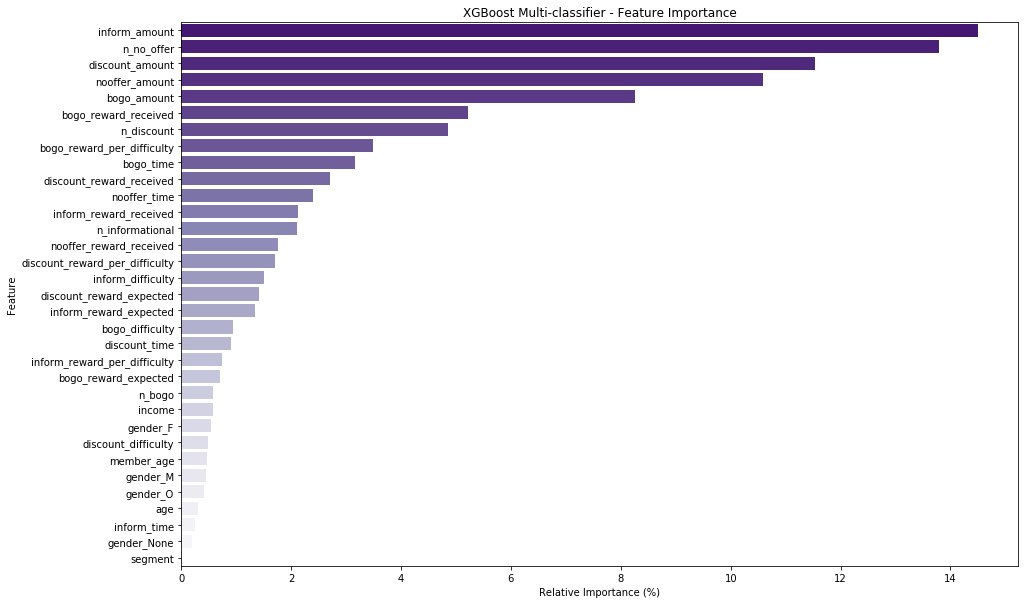

In [119]:
feat_importance = pd.DataFrame(xgb_multi.feature_importances_* 100)
feat_importance = feat_importance.set_index(np.array(X_train.columns))
feat_importance.columns = ['pct']
feat_importance = feat_importance.sort_values(by='pct',ascending=False)

# Plot features importance of XGBoost model
sns.barplot(data= feat_importance,
            x='pct',y=feat_importance.index,
                palette='Purples_r')

plt.ylabel('Feature')
plt.xlabel('Relative Importance (%)')
plt.title('XGBoost Multi-classifier - Feature Importance')

#### Summary
- Demographic data seem to play very little role in predicting offer type
- In contrast, the statistics of each offer type show a much larger influence
- The __least important__ features are in fact the clustering features. It did not create any value to the model

### Tuning

Use the existing __XGBoost Multiclassifier__ and try to improve upon its performance by running a randomized __grid search__ with 5-fold cross validation over a pre-defined parameter parameter space.

In [122]:
# Define parameters grid
parameters =  {
    'n_estimators': [1000, 1500],
    'learning_rate': [0.01,0.02], 
    'max_depth': [5,7,9,11],
    'min_child_weight': [1, 5,10],
}

# Create cross validation object for randomized grid search
random_grid = RandomizedSearchCV(xgb_multi, param_distributions=parameters, cv=5, scoring='accuracy', n_iter=5,return_train_score=True)

random_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster=None,
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=15, gamma=0,
                                           gpu_id=-1, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=0.01, max_delta_step=0,
                                           max_depth=6, min_child_weight=1,
                                           missing=nan,
                                           monotone_c...
                                           scale_pos_weight=None, silent=1,
                                           subsample=1, tree_method=None,
                              

In [123]:
# Collect metrics for best estimator and rerun the tuned model
train_preds, test_preds, metrics = run_validation(X_train, X_test, y_train, y_test, random_grid.best_estimator_)


Validation metrics:
Accuracy score       : 0.9445


In [124]:
random_grid.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=15,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.02,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, num_classes=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0.9,
              reg_lambda=0.1, scale_pos_weight=None, silent=1, subsample=1,
              tree_method=None, validate_parameters=False, ...)

#### Observations
- Test performance improved by __3%__ on __model fit__

__Best Hyperparameter__
- max_depth=5
- min_child_weight=1
- n_estimators=1000
- learning_rate=0.02

In [125]:
pd.DataFrame(random_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,438.060366,577.249726,2.932539,2.333294,1000,1,9,0.02,"{'n_estimators': 1000, 'min_child_weight': 1, ...",0.932381,0.933221,0.942857,0.934426,0.938209,0.936218,0.003872,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,84.773594,6.882581,0.824663,0.220259,1000,5,5,0.02,"{'n_estimators': 1000, 'min_child_weight': 5, ...",0.935321,0.933641,0.945378,0.938209,0.944094,0.939328,0.004668,2,0.998949,0.998844,0.998739,0.998214,0.998740,0.998697,0.000254
2,228.287217,25.926781,2.203807,0.322107,1500,10,11,0.01,"{'n_estimators': 1500, 'min_child_weight': 10,...",0.931121,0.934061,0.943697,0.939050,0.942413,0.938067,0.004814,3,0.998949,0.999055,0.999160,0.998950,0.998950,0.999013,0.000084
3,206.297171,10.348376,2.658272,0.388454,1500,5,9,0.01,"{'n_estimators': 1500, 'min_child_weight': 5, ...",0.927761,0.929021,0.943697,0.938630,0.941572,0.936134,0.006538,5,0.999790,0.999895,0.999685,0.999790,0.999790,0.999790,0.000066
4,91.860724,4.082804,1.189386,0.355113,1000,1,5,0.02,"{'n_estimators': 1000, 'min_child_weight': 1, ...",0.937421,0.934901,0.945798,0.937369,0.942833,0.939664,0.004016,1,0.999580,0.999685,0.999685,0.999685,0.999685,0.999664,0.000042


In [141]:
# Extract scoring data for train and test data
score = pd.DataFrame()
score['train_scores'] = random_grid.cv_results_['mean_train_score']
score['test_scores'] = random_grid.cv_results_['mean_test_score']
score['max_depth'] = random_grid.cv_results_['param_max_depth']

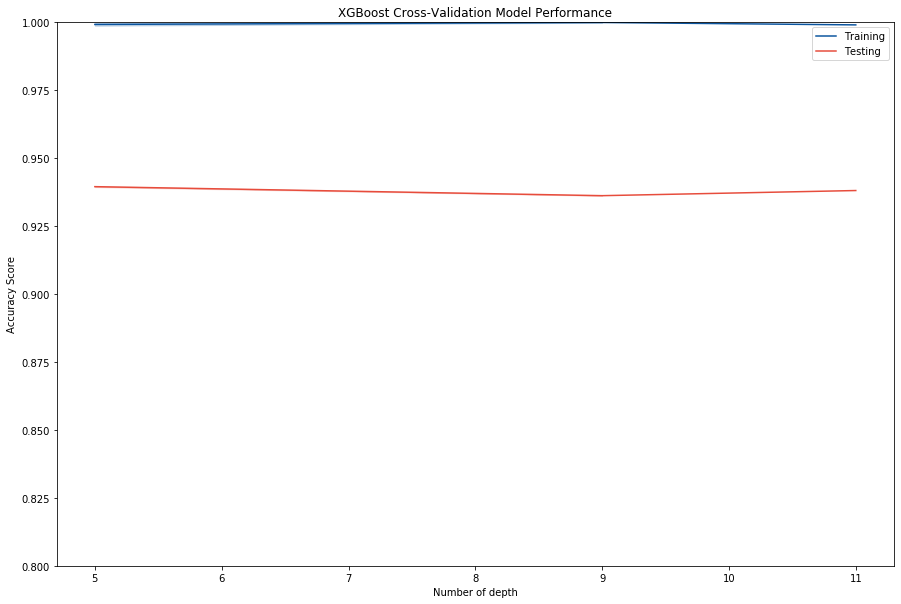

In [142]:
# Plot performance
sns.lineplot(data=score,x='max_depth', y= 'train_scores', label='Training')
sns.lineplot(data=score,x='max_depth', y= 'test_scores', label='Testing', color='#e74c3c')

# Format plot
plt.ylim(.8, 1.0)
plt.ylabel('Accuracy Score')
plt.xlabel('Number of depth')
plt.title('XGBoost Cross-Validation Model Performance')
plt.show()

- The model is a bit overfitting as we can see that the model fit it so well in train dataset but it does not perform that well in test dataset as there is huge gap (~5%) between them.

In [139]:
# Get parameters of gest model
random_grid.best_params_

{'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.02}

#### Observations
- The influence of __offer types__ has further decreases, from a combined importance of 3% to 2% for offers seen just before making a transaction and from 13% to 11% for offers seen in the past
- While the __most important__ feature remains "__amount_prev_log__" (28%), "income" has just lost its second place to "__member_age__" (13%)

Overall, one can say that the new set of parameters has caused feature importance to __change__ for multiple independent variables.

In [130]:
# Save model
joblib.dump(random_grid.best_estimator_, "xgb_multi.pkl", compress = 1)

# Re-load from file to check if everything is correct
joblib_model = joblib.load("xgb_multi.pkl")

# Calculate the accuracy
score = joblib_model.score(X_test, y_test)
score

0.9445098039215686

***

## 3 - Results

### 3.1 - Model Evaluation and Validation

### Multi-classifier Model
#### Model Performance
- The model achieved an accuracy score of 0.9445 
- The difference between training and testing performance may indicate that our model is overfitting

__Best Hyperparameter of the model is__:
- max_depth=5
- min_child_weight=1
- n_estimators=1000
- learning_rate=0.02

#### Feature Importance
- Demographic data seem to play very little role in predicting offer type
- In contrast, the statistics of each offer type show a much larger influence
- The least important features are in fact the segment which does not create any value to the model

***

## 4 - Conclusion
The goal of this project was to optimize Starbucks' promotion strategy or more specifically to maximize transaction profits per user by giving the right offer type. We have used XGBoost multiclassifier to make a prediction and able to achieve an accuracy score of 94%, which is quite decent. 

However, since the data used for modeling is only a simulated data and it is just a small proportion of the Starbucks data. Hence, it is advised to do an AB test in order to improve the promotion strategy within the Starbucks rewards app and optimize the model along the way. Additionally, before that, we can also run an A/A test before running A/B testing just to be sure that the final conclusion is true and the potential risk will be minimized too before we scale it up to the whole population.

***

## 5 - Limitations & Improvements
First of all, as mentioned in conclusion section,  the data at hand are not only simulated but more importantly, it is just a simplified version of tracking data from the Starbucks rewards app, it remains unclear if both developed solutions are applicable in real-life. Apart from that, there is still a room for improvement to increase the accuracy of the model that not only predicts well in this data, but also able to generalize well on unseen data in a much bigger population.

Clustering clearly, from the results, we can see that the group that we have found did not create any value to the model. This might be due to the sparsity of the data, which makes the K means not able to capture any valuable information since it is found that the variance of many columns are not huge.
Modeling In here, my objective is to solve build a model that will predict the most effective offer type for each user. Hence I did not put a lot of focus on using a more advanced model to increase the accuracy. Further exploration can be done for this part like stacking, which is combining a few algorithm to predict the target variable.
